# **Point Net - Classification**

In this notebook, we will use the classification version of point net to classify objects from the shapenet dataset

In [12]:
import os
import re
from glob import glob
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import open3d as o3
# from open3d import JVisualizer # For Colab Visualization
# from open3d.web_visualizer import draw # for non Colab

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# TEMP for supressing pytorch user warnings
import warnings
warnings.filterwarnings("ignore")

In Colab you can run this cell to download the dataset. If you would like to download the dataset to your PC visit the url and the dataset will automatically download as a zip 

WARNING: Downloading the dataset will take a long time

In [3]:
# Run this only if you don't already have the Dataset
# !wget -nv https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip --no-check-certificate
# !unzip shapenetcore_partanno_segmentation_benchmark_v0.zip
# !rm shapenetcore_partanno_segmentation_benchmark_v0.zip

### Get the data

In [4]:
# General parameters
NUM_TRAIN_POINTS = 2500
NUM_TEST_POINTS = 10000
NUM_CLASSES = 16
ROOT = r'C:\Users\itber\Documents\datasets\shapenetcore_partanno_segmentation_benchmark_v0'

# model hyperparameters
GLOBAL_FEATS = 1024

BATCH_SIZE = 32

Helpers for our dataset

In [9]:
# get class - label mappings
CATEGORIES = {
    'Airplane': 0, 
    'Bag': 1, 
    'Cap': 2, 
    'Car': 3,
    'Chair': 4, 
    'Earphone': 5, 
    'Guitar': 6, 
    'Knife': 7, 
    'Lamp': 8, 
    'Laptop': 9,
    'Motorbike': 10, 
    'Mug': 11, 
    'Pistol': 12, 
    'Rocket': 13, 
    'Skateboard': 14, 
    'Table': 15}
                
# unique color map generated via
# https://mokole.com/palette.html
COLOR_MAP = {
    0  : (47, 79, 79),    # Airplane - darkslategray
    1  : (139, 69, 19),   # Bag - saddlebrown
    2  : (34, 139, 34),   # Cap - forestgreen
    3  : (75, 0, 130),    # Car - indigo
    4  : (255, 0, 0),     # column - red 
    5  : (255, 255, 0),   # window - yellow
    6  : (0, 255, 0),     # door - lime
    7  : (0, 255, 255),   # table - aqua
    8  : (0, 0, 255),     # chair - blue
    9  : (255, 0, 255),   # sofa - fuchsia
    10 : (238, 232, 170), # bookcase - palegoldenrod
    11 : (100, 149, 237), # board - cornflower
    12 : (255, 105, 180), # stairs - hotpink
    13 : (0, 0, 0)        # clutter - black
}


# Simple point cloud coloring mapping for part segmentation
def read_pointnet_colors(seg_labels):
    map_label_to_rgb = {
        1: [0, 255, 0],
        2: [0, 0, 255],
        3: [255, 0, 0],
        4: [255, 0, 255],  # purple
        5: [0, 255, 255],  # cyan
        6: [255, 255, 0],  # yellow
    }
    colors = np.array([map_label_to_rgb[label] for label in seg_labels])
    return colors

In [6]:
from torch.utils.data import DataLoader
from shapenet_dataset import ShapenetDataset

# train Dataset & DataLoader
train_dataset = ShapenetDataset(ROOT, npoints=NUM_TRAIN_POINTS, split='train', classification=True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Validation Dataset & DataLoader
valid_dataset = ShapenetDataset(ROOT, npoints=NUM_TRAIN_POINTS, split='valid', classification=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

# test Dataset & DataLoader (segmentation version for display)
test_dataset = ShapenetDataset(ROOT, npoints=NUM_TEST_POINTS, split='test', classification=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

### Explore the training data

In [36]:
sample_dataset = train_dataset = ShapenetDataset(ROOT, npoints=20000, split='train', 
                                                 classification=False, normalize=False)

In [37]:
points, seg = sample_dataset[4000]

pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points)
pcd.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

o3.visualization.draw_plotly([pcd])
# draw(pcd)

Explore class frequencies and plot barchart

In [7]:
total_train_targets = []
for (_, targets) in train_dataloader:
    total_train_targets += targets.reshape(-1).numpy().tolist()

total_train_targets = np.array(total_train_targets)

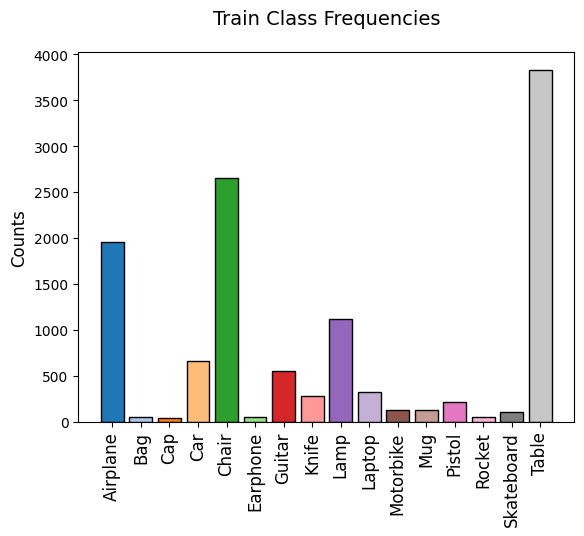

In [34]:
class_bins = np.bincount(total_train_targets)

plt.bar(list(CATEGORIES.keys()), class_bins, 
             color=mpl.cm.tab20(np.arange(0, NUM_CLASSES)),
             edgecolor='black')
plt.xticks(list(CATEGORIES.keys()), list(CATEGORIES.keys()), size=12, rotation=90)
plt.ylabel('Counts', size=12)
plt.title('Train Class Frequencies', size=14, pad=20);

In [48]:
from point_net import PointNetClassHead

points, targets = next(iter(train_dataloader))

classifier = PointNetClassHead(k=NUM_CLASSES, num_global_feats=GLOBAL_FEATS)
out, _, _ = classifier(points.transpose(2, 1))
print(f'Class output shape: {out.shape}')

Class output shape: torch.Size([32, 16])


Get device

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Define Loss for PointNet

For Point Net we will use the Categorical Cross Entropy loss with a regularization term that will enforce the high dimensional transform matrix to 0. We will also present the option for using the Balanced Cross Entropy loss via the 'alpha' argument which assigns a weight to each class this weights the importance of each example based on their class frequencies. We also provide the option to use the Focal loss which adds a modulating term to the Cross Entropy Loss $(1 - p_n)^\gamma$, this term forces the model to focus on hard examples (i.e. examples with low prediction probability).

### Begin Training Model

In [46]:
import torch.optim as optim
from point_net_loss import PointNetLoss

EPOCHS = 25
LR = 0.01
REG_WEIGHT = 0.001 

optimizer = optim.Adam(classifier.parameters(), lr=LR)
criterion = PointNetLoss(reg_weight=REG_WEIGHT)

In [6]:
# stuff for training
num_train_batch = len(train_dataset)/BATCH_SIZE 
num_valid_batch = len(valid_dataset)/BATCH_SIZE 

# lists to store metrics
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []

# TRAIN ON EPOCHS
for epoch in range(1, EPOCHS):

    # place model in training mode
    classifier = classifier.train()
    _train_loss = []
    _train_accuracy = []
    for i, (points, targets) in enumerate(train_dataloader, 0):

        points = points.transpose(2, 1).to(device)
        targets = targets.squeeze().to(device)
        
        # zero gradients
        optimizer.zero_grad()
        
        # get predicted class logits
        preds, _, A = classifier(points)
        
        # compute regularization term to enforce orthogonality on the feature Transformation
        I = torch.eye(64).unsqueeze(0).repeat(A.shape[0], 1, 1).to(device)
        reg = torch.linalg.norm(I - torch.bmm(A, A.transpose(2, 1)))

        # get loss and perform backprop
        loss = criterion(preds, targets) + REG_WEIGHT*reg/preds.size(0)
        loss.backward()
        optimizer.step()
        
        # get class predictions
        pred_choice = torch.softmax(preds, dim=1).argmax(dim=1) 
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct.item()/float(BATCH_SIZE)

        # update epoch loss and accuracy
        _train_loss.append(loss.item())
        _train_accuracy.append(accuracy)

        if i % 100 == 0:
            print('\t [%d: %d/%d] train loss: %f accuracy: %f' \
                  % (epoch, i, num_train_batch, loss.item(), accuracy))
        
    train_loss.append(np.mean(_train_loss))
    train_accuracy.append(np.mean(_train_accuracy))

    print(f'Epoch: {epoch} - Train Loss: {train_loss[-1]} - Train Accuracy: {train_accuracy[-1]}')

    # pause to cool down
    time.sleep(4)

    # get test results after each epoch
    with torch.no_grad():

        # place model in evaluation mode
        classifier = classifier.eval()

        _valid_loss = []
        _valid_accuracy = []
        for i, (points, targets) in enumerate(valid_dataloader, 0):

            points = points.transpose(2, 1).to(device)
            targets = targets.squeeze().to(device)

            preds, _, _ = classifier(points)
            # compute regularization term to enforce orthogonality on the feature Transformation
            I = torch.eye(64).unsqueeze(0).repeat(A.shape[0], 1, 1).to(device)
            reg = torch.linalg.norm(I - torch.bmm(A, A.transpose(2, 1)))
            loss = criterion(preds, targets) + REG_WEIGHT*reg/preds.size(0)

            pred_choice = torch.softmax(preds, dim=1).argmax(dim=1) 
            correct = pred_choice.eq(targets.data).cpu().sum()
            accuracy = correct.item()/float(BATCH_SIZE)

            # update epoch loss and accuracy
            _valid_loss.append(loss.item())
            _valid_accuracy.append(accuracy)

            if i % 100 == 0:
                print('\t [%d: %d/%d] %s loss: %f accuracy: %f' \
                      % (epoch, i, num_valid_batch, 'validation', loss.item(), accuracy))
        
        valid_loss.append(np.mean(_valid_loss))
        valid_accuracy.append(np.mean(_valid_accuracy))
        print(f'Epoch: {epoch} - Validation Loss: {valid_loss[-1]} - Validation Accuracy: {valid_accuracy[-1]}')

        # pause to cool down
        time.sleep(4)

    torch.save(classifier.state_dict(), 'cls/cls_model_%d.pth' % epoch)

274.0

### Test Model performance

In [47]:
MODEL_PATH = 'cls/cls_model_4.pth'

classifier = PointNetClassHead(num_points=NUM_TEST_POINTS, num_global_feats=GLOBAL_FEATS, k=NUM_CLASSES).to(device)
classifier.load_state_dict(torch.load(MODEL_PATH))
classifier.eval();

In [124]:
from random import randrange

# torch.cuda.empty_cache() # release GPU memory
# points, seg = next(iter(test_dataloader))

# get random sample from test data 
random_idx = randrange(len(test_dataset))
points, seg = test_dataset.__getitem__(random_idx)

with torch.no_grad():
    points = points.unsqueeze(0).transpose(2, 1).to(device)
    targets = targets.squeeze().to(device)

    preds, _, _ = classifier(points)
    preds = torch.softmax(preds, dim=1)
    pred_choice = preds.squeeze().argmax() 

Inspect the results

In [125]:
pred_class = list(CATEGORIES.keys())[pred_choice.cpu().numpy()]
pred_prob = preds[0, pred_choice]
print(f'The predicted class is: {pred_class}, with probability: {pred_prob}')

The predicted class is: Chair, with probability: 0.920298159122467


Visualize the probabilities

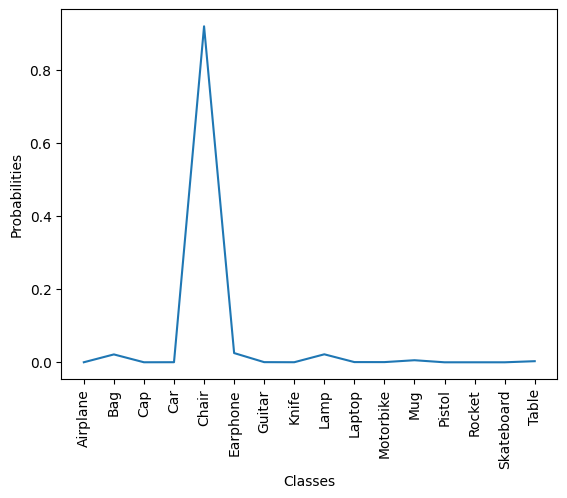

In [126]:
plt.xticks(list(CATEGORIES.values()), list(CATEGORIES.keys()), rotation=90)
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.plot(list(classes_dict.values()), preds[0]);

In [127]:
cloud = o3.geometry.PointCloud()
cloud.points = o3.utility.Vector3dVector(points[0, :, :].T)
cloud.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))
draw(cloud)

WebVisualizer(window_uid='window_2')